In [136]:
#Import required packages
import cv2 as cv
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2 as cv
import numpy as np
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader,random_split
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd
import random
from sklearn.metrics import confusion_matrix

In [137]:
#Insert filepath for local files  FOR THIBAUT
basepath = r"C:\Users\Thibaut Goldsborough\Documents\Seth_BoneMarrow\Data\BoneMarrow_smallerfile2"
readpath = basepath + "\\Raw_Images"
outpath = basepath + "\\Outputs"
file_prefix="\\smaller_file2_"

num_images=10000

image_dim=64 #Dim of the final images

In [138]:
df=pd.read_csv(outpath+"\\cell_info.csv")
cell_names=np.load(outpath+"\\image_ID.npy")
cell_names=[int(cell_name) for cell_name in cell_names]

if sum(df["Cell_ID"].to_numpy()!=cell_names)!=0:
    print("Error, dataframe cell ID do not match with entries saved during image processing step")


In [139]:
image_dict={}

for cell_name in cell_names:
    image_dict[cell_name]={}


#Find Channels
names=[]
for entry in os.listdir(outpath): #Read all files
    if os.path.isfile(os.path.join(outpath, entry)):
        if entry!='image_ID.npy':
            names.append(entry)


channels=[name[:-4] for name in names if name[-4:]=='.npy']

print("Channels found:",channels)

data_dict={}
for channel in channels:
    data_dict[channel]=np.load(outpath+"\\"+channel+'.npy')

#Break up array

for channel in data_dict:
    dims=data_dict[channel].shape
    n=dims[0]//image_dim
    l=dims[1]//image_dim
    index=0
    for i in range(n):
        for j in range(l):
            img=data_dict[channel][i*image_dim:i*image_dim+image_dim,j*image_dim:j*image_dim+image_dim]
            image_dict[cell_names[index]][channel]=img
            index+=1



Channels found: ['Ch1', 'Ch11', 'Ch11_mask', 'Ch1_mask', 'Ch2', 'Ch2_mask', 'Ch3', 'Ch3_mask', 'Ch6', 'Ch6_mask', 'Ch7', 'Ch7_mask', 'Ch9', 'Ch9_mask']


In [140]:
def to_onehot(my_list):
    return_list=[]
    for i,elem in enumerate(my_list):
        j=np.where(np.unique(labels)==elem)
        return_list.append(np.zeros((len(np.unique(my_list)))))
        return_list[-1][j]=1
    return np.array(return_list)

In [141]:
Channels=['Ch1']  #Channel to be fed to the NN

# Slightly overkill method to make absolutely sure the images are in order
images_with_index = []
for image_i in image_dict:
    image=cv.merge([image_dict[image_i][i] for i in Channels])
    images_with_index.append((int(image_i),image))
    
images_with_index.sort()

In [142]:
images=[image[1] for image in images_with_index]
names=[image[0] for image in images_with_index]
names_arg=np.argsort([image[0] for image in images_with_index])
labels=df['Cell_Type'].to_numpy()
labels=to_onehot(labels[names_arg])

In [165]:
labels=df['Cell_Type'].to_numpy()

In [173]:
0.01*10000

100.0

In [175]:
sum(labels==3)

30

In [143]:
mini=int(round(abs(np.array(images).min()),0))
images=images+abs(np.array(images).min())
mean=np.array(images).mean()
maxi=np.array(images).max()
std=np.array(images).std()

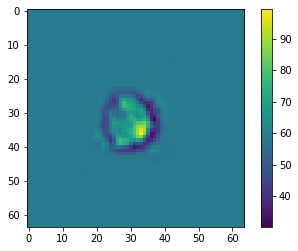

In [144]:
plt.imshow(images[0])
plt.colorbar()

In [145]:
#Split data into training and validation, just looking at first images now

validation_split = 0.8
test_split = 0.9

train_end=int(validation_split*len(images))
val_end=int(test_split*len(images))

train_data1=images[:train_end]
validation_data1=images[train_end:val_end]
test_data1=images[val_end:]

train_labels=labels[:train_end]
validation_labels=labels[train_end:val_end]
test_labels=labels[val_end:]

train_ID=names[:train_end]
validation_ID=names[train_end:val_end]
test_ID=names[val_end:]


In [146]:
#Transform data into tensors, normalize images
transform_basic = transforms.Compose(
    [transforms.ToPILImage(),
     transforms.ToTensor()
])

# custom dataset
class CellDataset():
    def __init__(self, images,labels, transforms=None):
        self.X = images
        self.Y=  labels
        self.transforms = transforms
         
    def __len__(self):
        return (len(self.X))
    
    def __getitem__(self, i):
        data = self.X[i]
        label=self.Y[i]
        data = np.asarray(data).astype(np.uint8)
        
        if self.transforms:
            data = self.transforms(data)
        
        return data,label


train_data_basic = CellDataset(train_data1,train_labels, transform_basic)
#Create DataLoaders
train_loader_basic = DataLoader(train_data_basic, batch_size=100, shuffle=False)

#data=next(iter(train_loader_basic))[0] Don't delete this is useful


def get_mean_std(loader):
    #https://stackoverflow.com/questions/48818619/pytorch-how-do-the-means-and-stds-get-calculated-in-the-transfer-learning-tutor
    mean = 0.
    std = 0.
    for images, _ in loader:
        batch_samples = images.size(0) # batch size (the last batch can have smaller size!)
        images = images.view(batch_samples, images.size(1), -1)
        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)

    mean /= len(loader.dataset)
    std /= len(loader.dataset)
    return mean, std


mean_loader,std_loader=get_mean_std(train_loader_basic)

In [148]:
# #Free up Space  #Optional
# import gc

# del images
# del shuffle_list
# del data_dict
# del images_with_index

del train_data_basic
del train_loader_basic

# gc.collect()

In [149]:
import math
def polar_transform(images, transform_type='linearpolar'):
    images=np.array(images).reshape((len(images),1,60,60))
    """
    This function takes multiple images, and apply polar coordinate conversion to it.
    """
    
    (N, C, H, W) = images.shape

    for i in range(images.shape[0]):

        img = images[i]  # [C,H,W]
        img = np.transpose(img, (1, 2, 0))  # [H,W,C]

        if transform_type == 'logpolar':
            img = cv.logPolar(img, (H // 2, W // 2), W / math.log(W / 2), cv.WARP_FILL_OUTLIERS).reshape(H, W, C)
        elif transform_type == 'linearpolar':
            img = cv.linearPolar(img, (H // 2, W // 2), W / 2, cv.WARP_FILL_OUTLIERS).reshape(H, W, C)
        img = np.transpose(img, (2, 0, 1))

        images[i] = torch.from_numpy(img)

    return images.reshape((len(images),60,60))


In [150]:
#Get information about CPU/GPU
def get_device():
    if torch.cuda.is_available():
        device = 'cuda:0'
    else:
        device = 'cpu'
    return device
device = get_device()
print(device)

cuda:0


In [151]:
def add_noise(image,noise_factor):
    return image+ noise_factor * torch.randn(*image.shape)



In [152]:
from typing import Type, Any, Callable, Union, List, Optional
from torch import Tensor

#from .._internally_replaced_utils import load_state_dict_from_url
#from ..utils import _log_api_usage_once



def conv3x3(in_planes: int, out_planes: int, stride: int = 1, groups: int = 1, dilation: int = 1) -> nn.Conv2d:
    """3x3 convolution with padding"""
    return nn.Conv2d(
        in_planes,
        out_planes,
        kernel_size=3,
        stride=stride,
        padding=dilation,
        groups=groups,
        bias=False,
        dilation=dilation,
    )


def conv1x1(in_planes: int, out_planes: int, stride: int = 1) -> nn.Conv2d:
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


class BasicBlock(nn.Module):
    expansion: int = 1

    def __init__(
        self,
        inplanes: int,
        planes: int,
        stride: int = 1,
        downsample: Optional[nn.Module] = None,
        groups: int = 1,
        base_width: int = 64,
        dilation: int = 1,
        norm_layer: Optional[Callable[..., nn.Module]] = None,
    ) -> None:
        super().__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError("BasicBlock only supports groups=1 and base_width=64")
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x: Tensor) -> Tensor:
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    # Bottleneck in torchvision places the stride for downsampling at 3x3 convolution(self.conv2)
    # while original implementation places the stride at the first 1x1 convolution(self.conv1)
    # according to "Deep residual learning for image recognition"https://arxiv.org/abs/1512.03385.
    # This variant is also known as ResNet V1.5 and improves accuracy according to
    # https://ngc.nvidia.com/catalog/model-scripts/nvidia:resnet_50_v1_5_for_pytorch.

    expansion: int = 4

    def __init__(
        self,
        inplanes: int,
        planes: int,
        stride: int = 1,
        downsample: Optional[nn.Module] = None,
        groups: int = 1,
        base_width: int = 64,
        dilation: int = 1,
        norm_layer: Optional[Callable[..., nn.Module]] = None,
    ) -> None:
        super().__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        width = int(planes * (base_width / 64.0)) * groups
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = norm_layer(width)
        self.conv2 = conv3x3(width, width, stride, groups, dilation)
        self.bn2 = norm_layer(width)
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x: Tensor) -> Tensor:
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class ResNet(nn.Module):
    def __init__(
        self,
        block: Type[Union[BasicBlock, Bottleneck]],
        layers: List[int],
        num_classes: int = 4,
        zero_init_residual: bool = False,
        groups: int = 1,
        width_per_group: int = 64,
        replace_stride_with_dilation: Optional[List[bool]] = None,
        norm_layer: Optional[Callable[..., nn.Module]] = None,
    ) -> None:
        super().__init__()
        #_log_api_usage_once(self)
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer

        self.inplanes = 64
        self.dilation = 1
        if replace_stride_with_dilation is None:
            # each element in the tuple indicates if we should replace
            # the 2x2 stride with a dilated convolution instead
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError(
                "replace_stride_with_dilation should be None "
                f"or a 3-element tuple, got {replace_stride_with_dilation}"
            )
        self.groups = groups
        self.base_width = width_per_group
        self.conv1 = nn.Conv2d(len(Channels), self.inplanes, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2, dilate=replace_stride_with_dilation[0])
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2, dilate=replace_stride_with_dilation[1])
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2, dilate=replace_stride_with_dilation[2])
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)  # type: ignore[arg-type]
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)  # type: ignore[arg-type]

    def _make_layer(
        self,
        block: Type[Union[BasicBlock, Bottleneck]],
        planes: int,
        blocks: int,
        stride: int = 1,
        dilate: bool = False,
    ) -> nn.Sequential:
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(
            block(
                self.inplanes, planes, stride, downsample, self.groups, self.base_width, previous_dilation, norm_layer
            )
        )
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(
                block(
                    self.inplanes,
                    planes,
                    groups=self.groups,
                    base_width=self.base_width,
                    dilation=self.dilation,
                    norm_layer=norm_layer,
                )
            )

        return nn.Sequential(*layers)

    def _forward_impl(self, x: Tensor) -> Tensor:
        # See note [TorchScript super()]
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

    def forward(self, x: Tensor) -> Tensor:
        return self._forward_impl(x)



def _resnet(
    arch: str,
    block: Type[Union[BasicBlock, Bottleneck]],
    layers: List[int],
    pretrained: bool,
    progress: bool,
    **kwargs: Any,
) -> ResNet:
    model = ResNet(block, layers, **kwargs)
    if pretrained:
        state_dict = load_state_dict_from_url(model_urls[arch], progress=progress)
        model.load_state_dict(state_dict)
    return model


In [153]:
#Train and evaluate model
### Training function
def train_epoch(NN, device, dataloader, loss_fn, optimizer,noise_factor=0):
    # Set train mode for both the encoder and the decoder
    NN.train()
    train_loss = []
    total=0
    correct=0
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    for image_batch,labels_batch in dataloader: # with "_" we just ignore the labels (the second element of the dataloader tuple)
        image_noisy = add_noise(image_batch,noise_factor) 
        image_batch = image_noisy.to(device)
        labels_batch=labels_batch.to(device)
        output = NN(image_batch)
        # Evaluate loss
        loss = loss_fn(output,labels_batch)
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss.append(loss.detach().cpu().numpy())

        total+=labels_batch.size(0)

        output=output.detach().cpu().numpy()
        labels=labels_batch.detach().cpu().numpy()

        correct+=np.sum(np.argmax(output,axis=1)==np.argmax(labels,axis=1))


    accuracy=100 * correct / total

    return np.mean(train_loss),accuracy


### validationing function
def validation_epoch(NN, device, dataloader, loss_fn):
    # Set evaluation mode for encoder and decoder
    NN.eval()
    total=0
    correct=0
    val_loss=[]

    with torch.no_grad(): # No need to track the gradients

        for image_batch,labels_batch in dataloader:
            # Move tensor to the proper device
            image_batch = image_batch.to(device)
            labels_batch = labels_batch.to(device)
            output = NN(image_batch)
            loss = loss_fn(output,labels_batch)

            total+=labels_batch.size(0)

            output=output.detach().cpu().numpy()
            labels=labels_batch.detach().cpu().numpy()

            correct+=np.sum(np.argmax(output,axis=1)==np.argmax(labels,axis=1))

            val_loss.append(loss.detach().cpu().numpy())

    accuracy=100 * correct / total
    return np.mean(val_loss),accuracy


In [154]:
### Plot losses at the end of training
def loss_over_epochs(diz_loss,num_epochs):
    plt.figure(figsize=(10,8))
    plt.semilogy(diz_loss['train_loss'], label='Train')
    plt.semilogy(diz_loss['val_loss'], label='Valid')
    plt.xlabel('Epoch')
    plt.ylabel('Average Loss')
    plt.grid()
    plt.legend()
    plt.title('Loss over ' + str(num_epochs) + ' epochs')
    plt.show()

    plt.figure(figsize=(10,8))
    plt.plot(diz_loss['train_acc'], label='Train')
    plt.plot(diz_loss['val_acc'], label='Valid')
    plt.xlabel('Epoch')
    plt.ylabel('Average Accuracy')
    plt.grid()
    plt.legend()
    plt.title('Loss over ' + str(num_epochs) + ' epochs')
    plt.show()

In [155]:
#https://github.com/pytorch/vision/blob/main/torchvision/models/resnet.py


def resnet18(pretrained: bool = False, progress: bool = True, **kwargs: Any) -> ResNet:
    return _resnet("resnet18", BasicBlock, [2, 2, 2, 2], pretrained, progress, **kwargs)


def resnet34(pretrained: bool = False, progress: bool = True, **kwargs: Any) -> ResNet:
    r"""ResNet-34 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet("resnet34", BasicBlock, [3, 4, 6, 3], pretrained, progress, **kwargs)


def resnet50(pretrained: bool = False, progress: bool = True, **kwargs: Any) -> ResNet:
    r"""ResNet-50 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet("resnet50", Bottleneck, [3, 4, 6, 3], pretrained, progress, **kwargs)


def resnet101(pretrained: bool = False, progress: bool = True, **kwargs: Any) -> ResNet:
    r"""ResNet-101 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet("resnet101", Bottleneck, [3, 4, 23, 3], pretrained, progress, **kwargs)


def resnet152(pretrained: bool = False, progress: bool = True, **kwargs: Any) -> ResNet:
    r"""ResNet-152 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet("resnet152", Bottleneck, [3, 8, 36, 3], pretrained, progress, **kwargs)


def resnext50_32x4d(pretrained: bool = False, progress: bool = True, **kwargs: Any) -> ResNet:
    r"""ResNeXt-50 32x4d model from
    `"Aggregated Residual Transformation for Deep Neural Networks" <https://arxiv.org/pdf/1611.05431.pdf>`_.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    kwargs["groups"] = 32
    kwargs["width_per_group"] = 4
    return _resnet("resnext50_32x4d", Bottleneck, [3, 4, 6, 3], pretrained, progress, **kwargs)


def resnext101_32x8d(pretrained: bool = False, progress: bool = True, **kwargs: Any) -> ResNet:
    r"""ResNeXt-101 32x8d model from
    `"Aggregated Residual Transformation for Deep Neural Networks" <https://arxiv.org/pdf/1611.05431.pdf>`_.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    kwargs["groups"] = 32
    kwargs["width_per_group"] = 8
    return _resnet("resnext101_32x8d", Bottleneck, [3, 4, 23, 3], pretrained, progress, **kwargs)


def wide_resnet50_2(pretrained: bool = False, progress: bool = True, **kwargs: Any) -> ResNet:
    r"""Wide ResNet-50-2 model from
    `"Wide Residual Networks" <https://arxiv.org/pdf/1605.07146.pdf>`_.
    The model is the same as ResNet except for the bottleneck number of channels
    which is twice larger in every block. The number of channels in outer 1x1
    convolutions is the same, e.g. last block in ResNet-50 has 2048-512-2048
    channels, and in Wide ResNet-50-2 has 2048-1024-2048.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    kwargs["width_per_group"] = 64 * 2
    return _resnet("wide_resnet50_2", Bottleneck, [3, 4, 6, 3], pretrained, progress, **kwargs)


def wide_resnet101_2(pretrained: bool = False, progress: bool = True, **kwargs: Any) -> ResNet:
    r"""Wide ResNet-101-2 model from
    `"Wide Residual Networks" <https://arxiv.org/pdf/1605.07146.pdf>`_.
    The model is the same as ResNet except for the bottleneck number of channels
    which is twice larger in every block. The number of channels in outer 1x1
    convolutions is the same, e.g. last block in ResNet-50 has 2048-512-2048
    channels, and in Wide ResNet-50-2 has 2048-1024-2048.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    kwargs["width_per_group"] = 64 * 2
    return _resnet("wide_resnet101_2", Bottleneck, [3, 4, 23, 3], pretrained, progress, **kwargs)

In [156]:
def Run_NN(train_data=train_data1,validation_data=validation_data1,model=resnet18(False,True),str_model='resnet18',batch_size=20,num_epochs = 25,polar=False,invert=False,lr=0.001):

        #Oversampling
    #Transform data into tensors, normalize images
    transform_train = transforms.Compose(
        [transforms.ToPILImage(),transforms.RandomHorizontalFlip(p=0.5),transforms.RandomVerticalFlip(p=0.5),transforms.RandomRotation(degrees=180,fill=mini),
       # transforms.GaussianBlur(kernel_size=(3, 3),sigma=(0.5,0.5)),
        transforms.ToTensor(),
        transforms.Normalize(mean_loader,std_loader)  
    ])

    #Transform data into tensors, normalize images
    transform_validation = transforms.Compose(
        [transforms.ToPILImage(),
        transforms.ToTensor(),
        transforms.Normalize(mean_loader,std_loader)  
    ])

    from torch.utils.data.sampler import WeightedRandomSampler
    counts=np.bincount(np.argmax(train_labels,axis=1))
    labels_weights = 1. / counts
    weights = labels_weights[np.argmax(train_labels,axis=1)]
    sampler = WeightedRandomSampler(weights, len(weights))

    if invert:
        transform_train = transforms.Compose(
        [transforms.ToPILImage(),transforms.RandomHorizontalFlip(p=0.5),transforms.RandomVerticalFlip(p=0.5),transforms.RandomRotation(degrees=180,fill=mini),
        transforms.ToTensor(),
        transforms.Normalize(mean_loader,std_loader),
        torchvision.transforms.RandomInvert(p=0.5) 
        ])




    if polar:
        transform_train = transforms.Compose(
        [transforms.ToPILImage(),
        transforms.GaussianBlur(kernel_size=(3, 3),sigma=(0.5,0.5)),
        transforms.ToTensor(),
        transforms.Normalize(mean_loader,std_loader)  
    ])

        train_data=polar_transform(train_data,'logpolar')
        validation_data=polar_transform(validation_data,'logpolar')


    train_data = CellDataset(train_data,train_labels, transform_train)
    validation_data = CellDataset(validation_data,validation_labels, transform_validation)



    #Create DataLoaders
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=False,sampler=sampler)
    validation_loader = DataLoader(validation_data, batch_size=batch_size, shuffle=True)

    ConvNet_simple=model
    ConvNet_simple.to(device)
    loss_fn = nn.CrossEntropyLoss()   
    optimizer = optim.Adam(ConvNet_simple.parameters(), lr = lr) 
    
    diz_loss = {'train_loss':[],'val_loss':[],'train_acc':[],'val_acc':[]}

    for epoch in range(num_epochs):

        train_loss,train_acc = train_epoch(ConvNet_simple,device,train_loader,loss_fn,optimizer)
        val_loss,val_acc = validation_epoch(ConvNet_simple,device,validation_loader,loss_fn)
        
        print('\n EPOCH',epoch+1,' \t train loss',train_loss,' \t val loss',val_loss,'\t train acc',train_acc,'\t val acc',val_acc)
        diz_loss['train_loss'].append(train_loss)
        diz_loss['val_loss'].append(val_loss)
        diz_loss['train_acc'].append(train_acc)
        diz_loss['val_acc'].append(val_acc)

    _ = loss_over_epochs(diz_loss,num_epochs)

    return diz_loss,str_model,ConvNet_simple,validation_loader,train_loader




In [157]:
def get_preds(NN,validation_loader):
    y_trues=[]
    y_preds=[]


    #validation_loader = DataLoader(validation_data, batch_size=int(len(validation_data)/10), shuffle=False)

    with torch.no_grad(): # No need to track the gradients

        for image_batch,labels_batch in validation_loader:
            # Move tensor to the proper device
            image_batch = image_batch.to(device)

            labels=labels_batch.to(device).detach().cpu().numpy()
            y_true=np.argmax(labels,axis=1)

            output=NN(image_batch).detach().cpu().numpy()
            y_pred=np.argmax(output,axis=1)

            y_trues.extend(list(y_true))
            y_preds.extend(list(y_pred))     



    conf=confusion_matrix(y_trues, y_preds,labels=[0,1,2])

    return y_trues,y_preds,conf



In [158]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

#from plotcm import plot_confusion_matrix
#plt.figure(figsize=(5,5),dpi=100)
##plot_confusion_matrix(conf, ["Singlet","Doublet","Debris"],normalize=True)


In [159]:
#Saving the model outputs

def save_output(diz_loss,str_model,y_trues,y_preds,conf):
    name=str_model
    mean_acc=round(np.mean(diz_loss['val_acc'][-5:]),2)
    new_dir=basepath+"\\Results\\"+name+'_'+str(mean_acc)

    dir=new_dir
    count=1
    while os.path.exists(dir):
        dir=new_dir+'('+str(count)+')'
        count+=1

    new_dir=dir
    os.mkdir(new_dir)

    destination1=new_dir+'\\Loss.csv'
    destination2=new_dir+'\\Predictions.csv'
    destination3=new_dir+'\\Confusion_mat.png'

    df = pd.DataFrame.from_dict(diz_loss)
    df.to_csv (destination1, index = False, header=True)

    df = pd.DataFrame()
    df['Cell_ID']  = validation_ID
    df['Prediction']  = y_preds
    df['Ground Truth']=y_trues
    df.to_csv (destination2, index = False, header=True)

    fig=plt.figure(figsize=(5,5),dpi=150)
    plot_confusion_matrix(conf, ["Singlet","Doublet","Debris"],normalize=True)
    fig.savefig(destination3,bbox_inches='tight', dpi=150)


In [160]:
# diz_loss,str_model,NN,validation_loader,train_loader=Run_NN(model=resnet18(False,True),str_model='Polar_resnet18',num_epochs=25,polar=True,batch_size=100)
# y_trues,y_preds,conf=get_preds(NN,validation_loader)
# #save_output(diz_loss,str_model,y_trues,y_preds,conf)

In [161]:
# diz_loss,str_model,NN,validation_loader,_=Run_NN(model=resnet50(False,True),str_model='Polar_resnet50',num_epochs=100,polar=True,batch_size=20)
# y_trues,y_preds,conf=get_preds(NN,validation_loader)
# save_output(diz_loss,str_model,y_trues,y_preds,conf)

In [162]:
# diz_loss,str_model,NN,validation_loader,_=Run_NN(model=resnet152(False,True),str_model='Polar_resnet152',num_epochs=100,polar=True,batch_size=20)
# y_trues,y_preds,conf=get_preds(NN,validation_loader)
# save_output(diz_loss,str_model,y_trues,y_preds,conf)

In [163]:
for trial in range(3):
    diz_loss,str_model,NN,validation_loader,train_loader=Run_NN(model=resnet18(),str_model='Resnet18'+'(trial='+str(trial)+')',num_epochs=100,polar=False,batch_size=20,lr=1e-4)
    y_trues,y_preds,conf=get_preds(NN,validation_loader)
    save_output(diz_loss,str_model,y_trues,y_preds,conf)


KeyboardInterrupt: 

In [ ]:
for trial in range(3):
    diz_loss,str_model,NN,validation_loader,train_loader=Run_NN(model=resnet50(),str_model='Resnet50'+'(trial='+str(trial)+')',num_epochs=100,polar=False,batch_size=20,lr=1e-4)
    y_trues,y_preds,conf=get_preds(NN,validation_loader)
    save_output(diz_loss,str_model,y_trues,y_preds,conf)


In [ ]:
for trial in range(3):
    diz_loss,str_model,NN,validation_loader,train_loader=Run_NN(model=resnet34(),str_model='Resnet34'+'(trial='+str(trial)+')',num_epochs=100,polar=False,batch_size=20,lr=1e-4)
    y_trues,y_preds,conf=get_preds(NN,validation_loader)
    save_output(diz_loss,str_model,y_trues,y_preds,conf)

In [ ]:
a=0/0 #Break

NameError: name 'train_loader' is not defined

In [164]:
diz_loss,str_model,NN,validation_loader,train_loader=Run_NN(model=resnet18(),str_model='Resnet18',num_epochs=100,polar=False,batch_size=20)
y_trues,y_preds,conf=get_preds(NN,validation_loader)
save_output(diz_loss,str_model,y_trues,y_preds,conf)


 EPOCH 1  	 train loss 1.3009307883414443  	 val loss 1.5962609926760194 	 train acc 37.5 	 val acc 16.5

 EPOCH 2  	 train loss 1.04273378543125  	 val loss 1.3298114000856875 	 train acc 52.475 	 val acc 29.2

 EPOCH 3  	 train loss 0.8763643116667518  	 val loss 1.181955121845007 	 train acc 58.7625 	 val acc 35.3

 EPOCH 4  	 train loss 0.7582739368305557  	 val loss 1.3535364558696747 	 train acc 63.5125 	 val acc 33.5

 EPOCH 5  	 train loss 0.6731127119155719  	 val loss 1.1655665108561515 	 train acc 66.95 	 val acc 38.7

 EPOCH 6  	 train loss 0.612058802130643  	 val loss 1.2280109651237727 	 train acc 68.1875 	 val acc 41.7

 EPOCH 7  	 train loss 0.572970149413567  	 val loss 0.9989990829527379 	 train acc 69.9 	 val acc 43.0

 EPOCH 8  	 train loss 0.544271234335336  	 val loss 1.0662465993836525 	 train acc 70.825 	 val acc 42.6

 EPOCH 9  	 train loss 0.5071245768563413  	 val loss 0.97486496090889 	 train acc 71.45 	 val acc 43.3

 EPOCH 10  	 train loss 0.480171520567

KeyboardInterrupt: 

In [ ]:
diz_loss,str_model,NN,validation_loader,_=Run_NN(model=resnet50(False,True),str_model='Resnet50_Norm',num_epochs=100,polar=False,batch_size=20)
y_trues,y_preds,conf=get_preds(NN,validation_loader)
save_output(diz_loss,str_model,y_trues,y_preds,conf)

In [ ]:
diz_loss,str_model,NN,validation_loader,_=Run_NN(model=resnet152(False,True),str_model='Resnet152_Norm',num_epochs=100,polar=False,batch_size=20)
y_trues,y_preds,conf=get_preds(NN,validation_loader)
save_output(diz_loss,str_model,y_trues,y_preds,conf)

In [ ]:
blurrer =torchvision.transforms.RandomInvert(p=1)


with torch.no_grad(): # No need to track the gradients

    for image_batch,labels_batch in train_loader:
        # Move tensor to the proper device
        #polar_transform(image_batch,'linearpolar')
        # for label in labels_batch:
        #     labels.append(label.numpy())
            
        for image in image_batch:

            plt.imshow(blurrer(image).detach().cpu().numpy()[0],vmin=-7,vmax=7)
            print(blurrer(image).detach().cpu().numpy()[0][0,0])
            plt.colorbar()
            plt.show()

            plt.imshow(image.detach().cpu().numpy()[0],vmin=-7,vmax=7)
            print(image.detach().cpu().numpy()[0][0,0])
            plt.colorbar()
            plt.show()
            #break
        break


In [ ]:
max(diz_loss['val_acc'])

In [ ]:
data=next(iter(train_loader))

In [ ]:
data[1]

In [ ]:
mini=int(round(abs(np.array(images).min()),0))
images=images+abs(np.array(images).min())
mean=np.array(images).mean()
maxi=np.array(images).max()
std=np.array(images).std()

ratio=255/images.max()
images=images*ratio

mini=int(mini*ratio)

In [ ]:
import numpy as np
a=np.random.randn(10,10)

b=transforms.ToTensor(a)


In [ ]:
a.mean()